In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

KeyboardInterrupt: 

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. YOLLAR (Ekran görüntüsündeki yapıya göre güncellendi) ---
# Görüntüde klasör uclm_full_analysis içinde değil, doğrudan content altında görünüyor.
BASE_PATH = '/content/otuz'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# Modelin Drive'daki yolu
MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/Resnet_model_with_BUSI.keras'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DA_LR = 0.0005

# --- 2. VERİ YÜKLEYİCİLER (Zekice Bölümleme) ---

# A) Train Jeneratörü
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

# B) Test Klasörünü %20 Val (Kontrol) - %80 Pure Test (Sınav) Bölüyoruz
test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Validation: Test klasörünün %20'si
val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

# Pure Test: Test klasörünün %80'i (Daha sonra predict için kullanacağız)
pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=False
)

# --- 3. MODELİ YÜKLE VE HAZIRLA ---
print(f"🔄 BUSI Ön Eğitimli ResNet50 yükleniyor...")
if not os.path.exists(MODEL_PATH):
    print("❌ HATA: Model bulunamadı! Lütfen Drive yolunu kontrol et.")
else:
    model = load_model(MODEL_PATH)
    model.trainable = True # Domain Adaptation için tüm katmanları açtık

    model.compile(optimizer=Adam(learning_rate=DA_LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. CALLBACKS ---
    checkpoint = ModelCheckpoint('/content/best_resnet_DA_30.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    # Patience değerini biraz artırdım (8), ResNet bazen geç açılır
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # --- 5. EĞİTİM (DOMAIN ADAPTATION) ---
    print("\n🚀 ResNet DA_30 Eğitimi Başlıyor...")
    model.fit(
        train_gen,
        epochs=50,
        validation_data=val_gen,
        callbacks=[checkpoint, early_stop]
    )

    # --- 6. DRIVE'A KAYDET ---
    save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/DA_Results/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    model.save(os.path.join(save_dir, "resnet_DA_30_final.keras"))
    print(f"✅ DA_30 Modeli başarıyla kaydedildi.")

KeyboardInterrupt: 

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. YOLLAR ---
BASE_PATH = '/content/elli'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test') # Büyük olan test klasörün

MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/Resnet_model_with_BUSI.keras'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DA_LR = 0.0005

# --- 2. VERİ YÜKLEYİCİLER (Zekice Bölümleme) ---

# A) Train Jeneratörü (Tamamı kullanılıyor)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

# B) Test Klasörünü %20 Val - %80 Test Olarak Bölüyoruz
test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2 # Buradaki %20, eğitim sırasında kontrol (Validation) olacak
)

# Validation: Test klasörünün içinden %20'lik dilim
val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

# Pure Test: Test klasörünün geri kalan %80'lik dilimi (ASIL SINAV)
pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=False # 'training' burada %80'i temsil eder
)

# --- 3. MODELİ YÜKLE VE HAZIRLA ---
print(f"🔄 BUSI Ön Eğitimli ResNet50 yükleniyor...")
if not os.path.exists(MODEL_PATH):
    print("❌ HATA: Model bulunamadı!")
else:
    model = load_model(MODEL_PATH)
    model.trainable = True

    model.compile(optimizer=Adam(learning_rate=DA_LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. CALLBACKS ---
    checkpoint = ModelCheckpoint('/content/best_resnet_DA_50.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

    # --- 5. EĞİTİM (DOMAIN ADAPTATION) ---
    print("\n🚀 DA_50 Eğitimi Başlıyor (Validation: Testin %20'si)...")
    model.fit(
        train_gen,
        epochs=30,
        validation_data=val_gen,
        callbacks=[checkpoint, early_stop]
    )

    # --- 6. KAYDET ---
    save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/DA_Results/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    model.save(os.path.join(save_dir, "resnet_DA_50_final.keras"))
    print(f"✅ DA_50 Modeli kaydedildi.")

Found 1081 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Found 868 images belonging to 3 classes.
🔄 BUSI Ön Eğitimli ResNet50 yükleniyor...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 40 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



🚀 DA_50 Eğitimi Başlıyor (Validation: Testin %20'si)...
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.5577 - loss: 1.6198
Epoch 1: val_accuracy improved from -inf to 0.41395, saving model to /content/best_resnet_DA_50.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5604 - loss: 1.6045 - val_accuracy: 0.4140 - val_loss: 16.7130
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8499 - loss: 0.4224
Epoch 2: val_accuracy improved from 0.41395 to 0.74884, saving model to /content/best_resnet_DA_50.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 695ms/step - accuracy: 0.8504 - loss: 0.4215 - val_accuracy: 0.7488 - val_loss: 2.3024
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9491 - loss: 0.1789
Epoch 3: val_accuracy improved from 0.74884 to 0.85581, saving model to /content/best_resnet_DA_50.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 694ms/step - accuracy: 0.9493 - loss: 0.1784 - val_accuracy: 0.8558 - val_loss: 0.5696
Epoch 4/30
34/34 ━━━━

🔄 ResNet DA_50 (Hızlı LR) Modeli Yükleniyor...
Found 868 images belonging to 3 classes.

🔍 1214 resim üzerinde final sınavı başlıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 718ms/step

🔥 RESNET DA_50 PURE TEST METRİKLERİ:
------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.8464    0.8750    0.8605       296
      malign     0.9078    0.7191    0.8025       178
      normal     0.8694    0.9289    0.8982       394

    accuracy                         0.8675       868
   macro avg     0.8745    0.8410    0.8537       868
weighted avg     0.8694    0.8675    0.8657       868



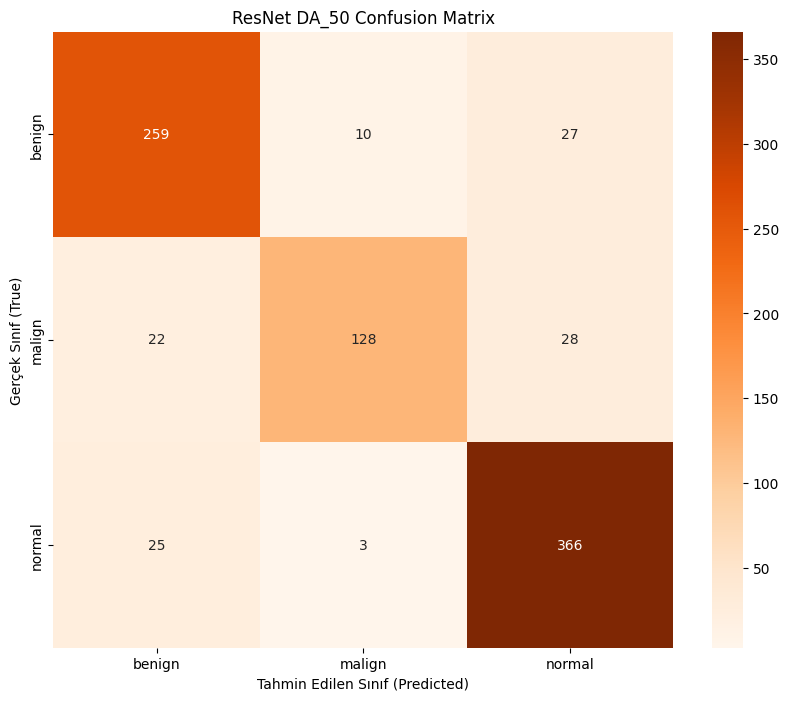


✅ FINAL ACCURACY: %86.75


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# 1. En İyi Kaydedilen Modeli Yükle
MODEL_PATH = '/content/best_resnet_DA_50.keras'
print(f"🔄 ResNet DA_50 (Hızlı LR) Modeli Yükleniyor...")
model = load_model(MODEL_PATH)

# 2. Pure Test Jeneratörü (Hiç görülmemiş %80'lik test verisi)
BASE_PATH = '/content/elli'
TEST_DIR = os.path.join(BASE_PATH, 'test')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
pure_test_gen = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='training', shuffle=False
)

# 3. Tahminleri Yap
print("\n🔍 1214 resim üzerinde final sınavı başlıyor...")
Y_pred = model.predict(pure_test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = pure_test_gen.classes
class_labels = list(pure_test_gen.class_indices.keys())

# 4. KARNE (Classification Report)
print("\n🔥 RESNET DA_50 PURE TEST METRİKLERİ:")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

# 5. CONFUSION MATRIX GÖRSELLEŞTİRME
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('ResNet DA_50 Confusion Matrix')
plt.ylabel('Gerçek Sınıf (True)')
plt.xlabel('Tahmin Edilen Sınıf (Predicted)')
plt.show()

# 6. Özet Sonuç
final_acc = np.sum(y_true == y_pred) / len(y_true)
print(f"\n✅ FINAL ACCURACY: %{final_acc*100:.2f}")

In [ ]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

# 1. denem.zip dosyasını dışarı çıkar (Eğer klasör yoksa)
ZIP_PATH = '/content/denem.zip'
EXTRACT_PATH = '/content/denem_resnet_50_v2'

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ denem.zip başarıyla çıkarıldı.")

# 2. ResNet DA_50 (Yeni Hızlı Versiyon) Modeli Yükle
model_path = '/content/best_resnet_DA_50.keras'
if os.path.exists(model_path):
    model = load_model(model_path)
    print("🔄 ResNet DA_50 (Hızlı LR) Modeli yüklendi. Tahminler başlıyor...\n")
else:
    print("❌ HATA: Model dosyası bulunamadı!")

# 3. Tahmin Fonksiyonu
def predict_external_images(folder_path):
    class_labels = ['benign', 'malign', 'normal']
    total_count = 0

    print(f"{'Resim Adı':<45} --> {'Tahmin':<15}")
    print("-" * 70)

    for img_name in sorted(os.listdir(folder_path)):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)

            # Resmi yükle ve ResNet formatına hazırla
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Tahmin
            preds = model.predict(img_array, verbose=0)
            score = np.max(preds)
            predicted_class = class_labels[np.argmax(preds)]

            print(f"{img_name:<45} --> {predicted_class} (%{score*100:.2f})")
            total_count += 1

    return total_count

# Testi Başlat
folder_to_test = os.path.join(EXTRACT_PATH, 'denem')
if not os.path.exists(folder_to_test):
    folder_to_test = EXTRACT_PATH

predict_external_images(folder_to_test)

✅ denem.zip başarıyla çıkarıldı.
🔄 ResNet DA_50 (Hızlı LR) Modeli yüklendi. Tahminler başlıyor...

Resim Adı                                     --> Tahmin         
----------------------------------------------------------------------
benign (100)-rotated1-rotated2.png            --> benign (%100.00)
benign (101)-rotated1.jpg                     --> benign (%100.00)
benign (101)-sharpened.jpg                    --> benign (%100.00)
benign (102)-rotated2-rotated1.png            --> benign (%100.00)
benign (103)-rotated2-rotated1.png            --> benign (%100.00)
benign (105)-rotated2-rotated2.png            --> benign (%100.00)
benign (105)-rotated2.png                     --> benign (%100.00)
benign (107)-rotated2-sharpened.png           --> benign (%100.00)
benign (108)-rotated2-rotated2.png            --> normal (%92.77)
benign (110)-sharpened-sharpened.png          --> benign (%100.00)
benign (111)-rotated1-sharpened.png           --> benign (%100.00)
malignant (105)-rotated32.pn

27

🔍 Pure Test seti üzerinde tahminler yapılıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 715ms/step

📝 CLASSIFICATION REPORT (UCLM DA_50 Final):
------------------------------------------------------------
              precision    recall  f1-score   support

      benign       0.72      0.66      0.69       296
      malign       0.70      0.63      0.66       178
      normal       0.75      0.82      0.78       394

    accuracy                           0.73       868
   macro avg       0.72      0.70      0.71       868
weighted avg       0.73      0.73      0.73       868



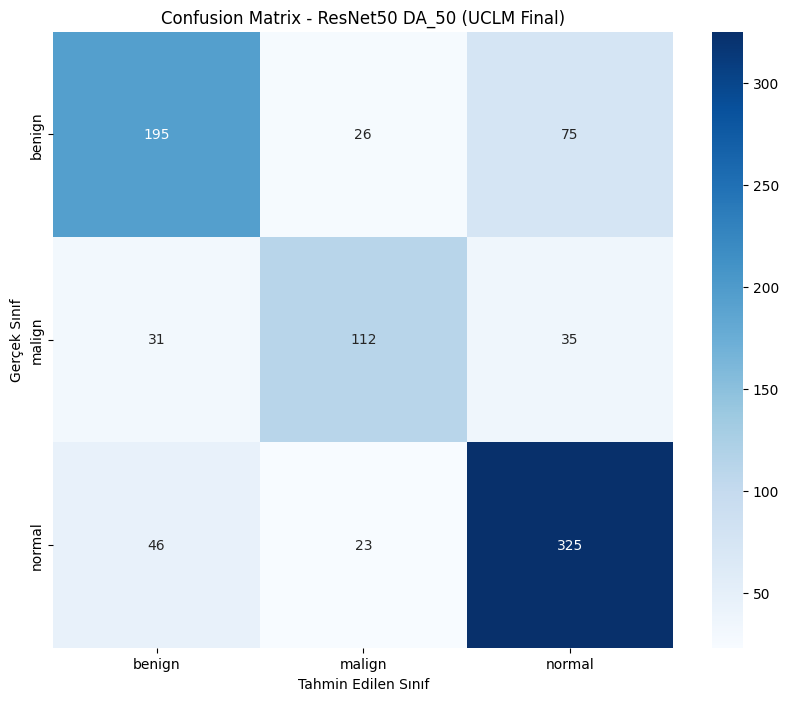


✅ PURE TEST FINAL ACCURACY: %72.81


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Tahminleri Al
print("🔍 Pure Test seti üzerinde tahminler yapılıyor...")
# pure_test_gen yukarıdaki koddan tanımlı gelmektedir
Y_pred = model.predict(pure_test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# 2. Gerçek Etiketleri Al
y_true = pure_test_gen.classes
class_labels = list(pure_test_gen.class_indices.keys())

# 3. Classification Report (Makale Tablosu)
print("\n📝 CLASSIFICATION REPORT (UCLM DA_50 Final):")
print("-" * 60)
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# 4. Confusion Matrix (Görselleştirme)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - ResNet50 DA_50 (UCLM Final)')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# 5. Genel Accuracy Skorunu Yazdır
final_acc = np.sum(y_true == y_pred) / len(y_true)
print(f"\n✅ PURE TEST FINAL ACCURACY: %{final_acc*100:.2f}")

In [ ]:
import zipfile
import os

DENEME_ZIP_PATH = '/content/denem.zip'
DENEME_EXTRACT_PATH = '/content/deneme_test_data'

if not os.path.exists(DENEME_EXTRACT_PATH):
    with zipfile.ZipFile(DENEME_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DENEME_EXTRACT_PATH)
    print("✅ denem.zip başarıyla çıkarıldı.")

# denem.zip içindeki jeneratörü hazırla
deneme_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
deneme_gen = deneme_datagen.flow_from_directory(
    DENEME_EXTRACT_PATH,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

✅ denem.zip başarıyla çıkarıldı.
Found 27 images belonging to 1 classes.


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

🧪 DENEM.ZIP TAHMİN LİSTESİ:
----------------------------------------
Resim: benign (100)-rotated1-rotated2.png  -->  Tahmin: benign (%81.92)
Resim: benign (101)-rotated1.jpg  -->  Tahmin: benign (%100.00)
Resim: benign (101)-sharpened.jpg  -->  Tahmin: benign (%88.33)
Resim: benign (102)-rotated2-rotated1.png  -->  Tahmin: benign (%99.82)
Resim: benign (103)-rotated2-rotated1.png  -->  Tahmin: benign (%100.00)
Resim: benign (105)-rotated2-rotated2.png  -->  Tahmin: benign (%99.94)
Resim: benign (105)-rotated2.png  -->  Tahmin: benign (%97.66)
Resim: benign (107)-rotated2-sharpened.png  -->  Tahmin: benign (%93.35)
Resim: benign (108)-rotated2-rotated2.png  -->  Tahmin: normal (%86.46)
Resim: benign (110)-sharpened-sharpened.png  -->  Tahmin: normal (%100.00)
Resim: benign (111)-rotated1-sharpened.png  -->  Tahmin: benign (%97.24)
Resim: malignant (105)-rotated32.png  -->  Tahmin: malign (%89.05)
Resim: malignant (106)-sharpened-rotated32.png  -->

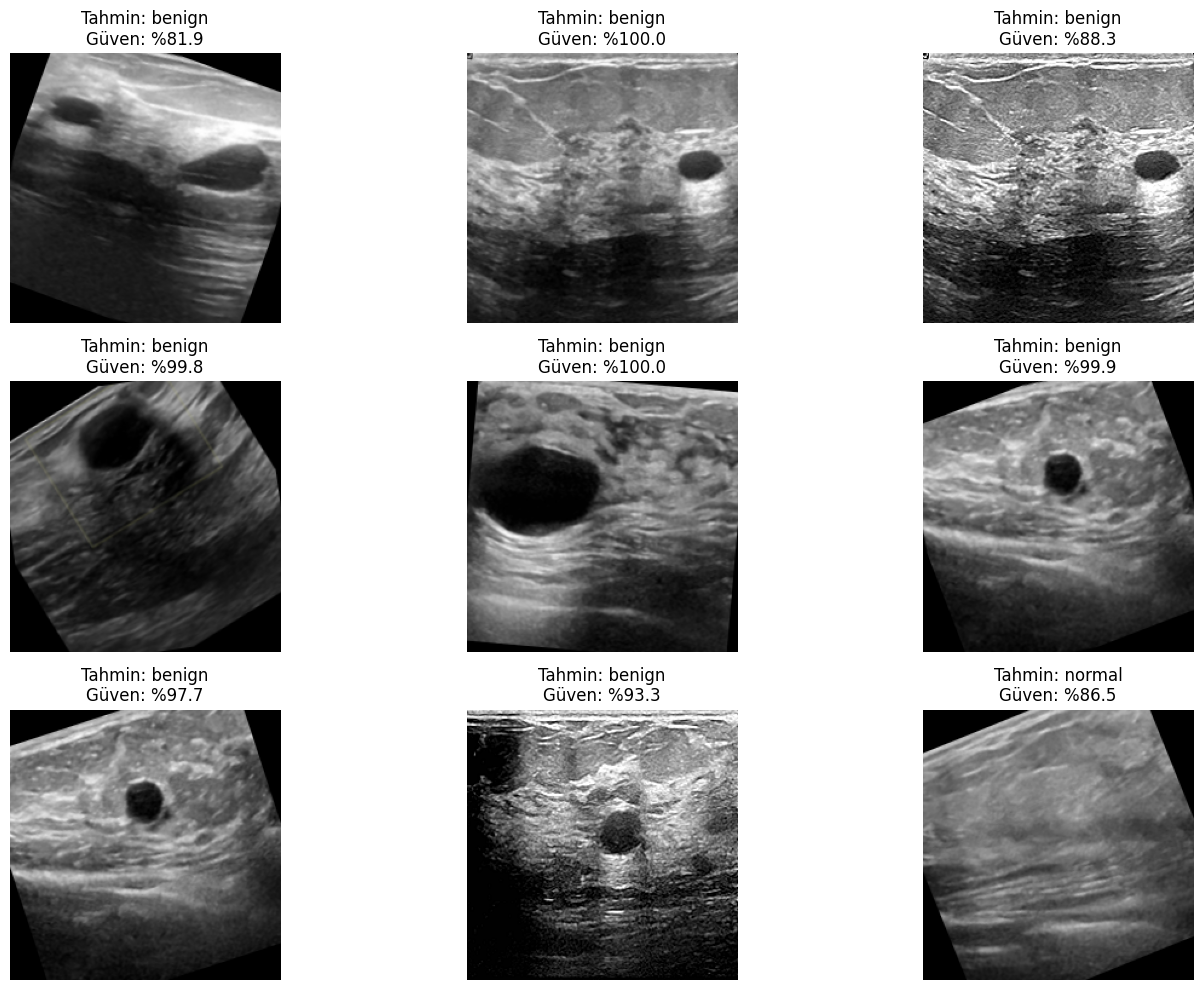

In [ ]:
# 1. Tahminleri al ve sınıflara eşleştir
class_map = {v: k for k, v in train_gen.class_indices.items()} # Ana modelin sınıf isimleri
predictions = model.predict(deneme_gen)
predicted_classes = np.argmax(predictions, axis=1)

print("\n🧪 DENEM.ZIP TAHMİN LİSTESİ:")
print("-" * 40)

# 2. Her resim için tek tek sonucu yazdır
for i, file_path in enumerate(deneme_gen.filepaths):
    file_name = os.path.basename(file_path)
    pred_name = class_map[predicted_classes[i]]
    confidence = np.max(predictions[i]) * 100
    print(f"Resim: {file_name}  -->  Tahmin: {pred_name} (%{confidence:.2f})")

# 3. Görsel kontrol
plt.figure(figsize=(15, 10))
for i in range(min(9, len(predicted_classes))):
    plt.subplot(3, 3, i+1)
    img = tf.keras.preprocessing.image.load_img(deneme_gen.filepaths[i])
    plt.imshow(img)
    plt.title(f"Tahmin: {class_map[predicted_classes[i]]}\nGüven: %{np.max(predictions[i])*100:.1f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

NASNET İÇİN DOMAİN ADAPTATİON %50 OLAN


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import preprocess_input # NASNet için özel preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. YOLLAR ---
# BASE_PATH ve MODEL_PATH kısımlarını kendi NASNet modeline göre güncellemelisin
BASE_PATH = '/content/uclm_full_analysis/elli'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# ÖNEMLİ: Daha önce BUSI ile eğittiğin NASNet modelinin yolu
NASNET_MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/Nasnet_Results/nasnet_model_with_BUSI.keras'

# NASNetLarge standart giriş boyutu 331x331'dir
IMAGE_SIZE = (224,224)
BATCH_SIZE = 16 # NASNet çok büyük olduğu için memory hatası almamak adına batch size düşürülür
DA_LR = 0.0001 # İstediğin gibi LR'yi biraz büyüttük

# --- 2. VERİ YÜKLEYİCİLER ---
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

# --- 3. MODELİ YÜKLE ---
print(f"🔄 BUSI Ön Eğitimli NASNetLarge yükleniyor...")
if not os.path.exists(NASNET_MODEL_PATH):
    print("❌ HATA: NASNet Modeli bulunamadı!")
else:
    model = load_model(NASNET_MODEL_PATH)
    model.trainable = True # Tüm katmanlar adaptasyon için açık

    model.compile(optimizer=Adam(learning_rate=DA_LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. CALLBACKS ---
    checkpoint = ModelCheckpoint('/content/best_nasnet_DA_50.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    # Tıkanma olursa LR'yi düşüren mekanizma
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

    # --- 5. EĞİTİM ---
    print("\n🚀 NASNet DA_50 Eğitimi Başlıyor...")
    model.fit(
        train_gen,
        epochs=30,
        validation_data=val_gen,
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

    # --- 6. KAYDET ---
    save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/NASNet_Results/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    model.save(os.path.join(save_dir, "nasnet_DA_50_final.keras"))
    print(f"✅ NASNet DA_50 Modeli kaydedildi.")

Found 1081 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
🔄 BUSI Ön Eğitimli NASNetLarge yükleniyor...

🚀 NASNet DA_50 Eğitimi Başlıyor...
Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.4158 - loss: 3.1160
Epoch 1: val_accuracy improved from -inf to 0.38605, saving model to /content/best_nasnet_DA_50.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.4162 - loss: 3.1138 - val_accuracy: 0.3860 - val_loss: 2.7391 - learning_rate: 1.0000e-04
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.4771 - loss: 2.3404
Epoch 2: val_accuracy improved from 0.38605 to 0.40465, saving model to /content/best_nasnet_DA_50.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 379ms/step - accuracy: 0.4771 - loss: 2.3405 - val_accuracy: 0.4047 - val_loss: 2.0460 - learning_rate: 1.0000e-04
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.4793 - loss: 2.2315
Epoch 3: val_accuracy improved from 0.40465 to 0.42791, saving model to /content/

KeyboardInterrupt: 

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. AYARLAR ---
BASE_PATH = '/content/uclm_full_analysis/elli'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
DA_LR = 0.0001 # Kaldığımız hız

# --- 2. VERİ YÜKLEYİCİLER ---
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
val_gen = test_val_datagen.flow_from_directory(TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=False)

# --- 3. MODELİ GERİ YÜKLE (En önemli kısım) ---
CHECKPOINT_PATH = '/content/best_nasnet_DA_50.keras'

if os.path.exists(CHECKPOINT_PATH):
    print(f"🔄 En iyi ağırlıklar ({CHECKPOINT_PATH}) yükleniyor, eğitim devam edecek...")
    model = load_model(CHECKPOINT_PATH)
else:
    # Eğer dosya silindiyse mecbur BUSI modelinden baştan başlarız
    print("⚠️ Checkpoint bulunamadı, BUSI modelinden baştan başlanıyor...")
    NASNET_MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/Nasnet_Results/nasnet_model_with_BUSI.keras'
    model = load_model(NASNET_MODEL_PATH)

# Modeli tekrar derle (LR'yi tazelemiş oluruz)
model.compile(optimizer=Adam(learning_rate=DA_LR), loss='categorical_crossentropy', metrics=['accuracy'])

# --- 4. CALLBACKS ---
checkpoint = ModelCheckpoint('/content/best_nasnet_DA_50.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# --- 5. EĞİTİMİ DEVAM ETTİR ---
#initial_epoch=8 diyerek logları düzgün tutabilirsin
model.fit(
    train_gen,
    epochs=30,
    initial_epoch=8,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# --- 6. KAYDET ---
save_path = "/content/drive/MyDrive/Ara Proje/saved_models/NASNet_Results/nasnet_DA_50_final.keras"
model.save(save_path)
print(f"✅ Model kaydedildi: {save_path}")

Found 1081 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
🔄 En iyi ağırlıklar (/content/best_nasnet_DA_50.keras) yükleniyor, eğitim devam edecek...
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.5331 - loss: 1.8636
Epoch 9: val_accuracy improved from -inf to 0.55814, saving model to /content/best_nasnet_DA_50.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.5332 - loss: 1.8624 - val_accuracy: 0.5581 - val_loss: 1.3443 - learning_rate: 1.0000e-04
Epoch 10/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5451 - loss: 1.6717
Epoch 10: val_accuracy improved from 0.55814 to 0.57674, saving model to /content/best_nasnet_DA_50.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 382ms/step - accuracy: 0.5452 - loss: 1.6719 - val_accuracy: 0.5767 - val_loss: 1.3210 - learning_rate: 1.0000e-04
Epoch 11/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5514 - loss: 1.6431
Epoch 11: val_accuracy improved from 0.57674 to 0.58605, saving model

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Ara Proje/saved_models/NASNet_Results/nasnet_DA_50_final.keras'

In [ ]:
import os
import shutil

# 1. Drive klasörünü zorla oluştur
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/NASNet_Results/DA_Results/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"✅ Klasör oluşturuldu: {save_dir}")

# 2. Eğitilen en iyi modeli Drive'a kopyala
source_path = '/content/best_nasnet_DA_50.keras'
dest_path = os.path.join(save_dir, "nasnet_DA_50_final.keras")

if os.path.exists(source_path):
    shutil.copy(source_path, dest_path)
    print(f"🚀 Başarıyla Kaydedildi: {dest_path}")
else:
    print("❌ Hata: Kaynak model dosyası bulunamadı!")

✅ Klasör oluşturuldu: /content/drive/MyDrive/Ara Proje/saved_models/NASNet_Results/DA_Results/
🚀 Başarıyla Kaydedildi: /content/drive/MyDrive/Ara Proje/saved_models/NASNet_Results/DA_Results/nasnet_DA_50_final.keras


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. YOLLAR ---
BASE_PATH = '/content/uclm_full_analysis/elli'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')
# Az önce hata aldığımız ama şimdi var olan klasör yolu
SAVE_DIR = "/content/drive/MyDrive/Ara Proje/saved_models/NASNet_Results/DA_Results/"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
DA_LR = 0.0001

# --- 2. VERİ YÜKLEYİCİLER ---
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
val_gen = test_val_datagen.flow_from_directory(TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=False)

# --- 3. MODELİ YÜKLE ---
# Az önce Drive'a manuel kopyaladığımız veya localde kalan en son ağırlık
CHECKPOINT_PATH = '/content/best_nasnet_DA_50.keras'

print(f"🔄 NASNetLarge 30. Epoch ağırlıklarıyla geri yükleniyor...")
model = load_model(CHECKPOINT_PATH)

# Modeli tekrar derle
model.compile(optimizer=Adam(learning_rate=DA_LR), loss='categorical_crossentropy', metrics=['accuracy'])

# --- 4. CALLBACKS ---
# Yeni dosya ismini v2 olarak belirleyelim ki karışmasın
checkpoint = ModelCheckpoint('/content/best_nasnet_DA_50_v2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)

# --- 5. EĞİTİM (30 -> 60) ---
print("\n🚀 NASNet DA_50 İkinci Tur (30-60 Epoch) Başlıyor...")
model.fit(
    train_gen,
    epochs=60,
    initial_epoch=30,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# --- 6. FİNAL KAYIT ---
final_save_path = os.path.join(SAVE_DIR, "nasnet_DA_50_60epoch_final.keras")
model.save(final_save_path)
print(f"✅ Başarıyla 60 Epoch tamamlandı ve kaydedildi: {final_save_path}")

Found 1081 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
🔄 NASNetLarge 30. Epoch ağırlıklarıyla geri yükleniyor...

🚀 NASNet DA_50 İkinci Tur (30-60 Epoch) Başlıyor...
Epoch 31/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.6055 - loss: 1.3201
Epoch 31: val_accuracy improved from -inf to 0.60930, saving model to /content/best_nasnet_DA_50_v2.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.6057 - loss: 1.3199 - val_accuracy: 0.6093 - val_loss: 1.0938 - learning_rate: 1.0000e-04
Epoch 32/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5792 - loss: 1.3903
Epoch 32: val_accuracy improved from 0.60930 to 0.61395, saving model to /content/best_nasnet_DA_50_v2.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 379ms/step - accuracy: 0.5793 - loss: 1.3909 - val_accuracy: 0.6140 - val_loss: 1.0815 - learning_rate: 1.0000e-04
Epoch 33/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5882 - loss: 1.3618
Epoch 33: val_accuracy did not improve f

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. YOLLAR ---
BASE_PATH = '/content/uclm_full_analysis/elli'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')
SAVE_DIR = "/content/drive/MyDrive/Ara Proje/saved_models/NASNet_Results/DA_Results/"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
DA_LR = 0.0001

# --- 2. VERİ YÜKLEYİCİLER ---
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
val_gen = test_val_datagen.flow_from_directory(TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=False)

# --- 3. MODELİ 60. EPOCH'TAN YÜKLE ---
# Drive'a az önce kaydettiğimiz final modelini baz alıyoruz
LAST_MODEL_PATH = os.path.join(SAVE_DIR, "nasnet_DA_50_60epoch_final.keras")

print(f"🔄 NASNetLarge 60. Epoch ağırlıklarıyla geri yükleniyor...")
model = load_model(LAST_MODEL_PATH)

# Modeli tekrar derle
model.compile(optimizer=Adam(learning_rate=DA_LR), loss='categorical_crossentropy', metrics=['accuracy'])

# --- 4. CALLBACKS ---
# Yeni dosya ismini v3 olarak belirleyelim
checkpoint = ModelCheckpoint('/content/best_nasnet_DA_50_v3.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# --- 5. EĞİTİM (60 -> 80) ---
print("\n🚀 NASNet DA_50 Üçüncü Tur (60-80 Epoch) Başlıyor...")
model.fit(
    train_gen,
    epochs=90,
    initial_epoch=60,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# --- 6. FİNAL KAYIT ---
final_save_path = os.path.join(SAVE_DIR, "nasnet_DA_50_80epoch_final.keras")
model.save(final_save_path)
print(f"✅ Hedef 80 Epoch tamamlandı: {final_save_path}")

Found 1081 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
🔄 NASNetLarge 60. Epoch ağırlıklarıyla geri yükleniyor...

🚀 NASNet DA_50 Üçüncü Tur (60-80 Epoch) Başlıyor...
Epoch 61/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.6924 - loss: 1.0362
Epoch 61: val_accuracy improved from -inf to 0.68837, saving model to /content/best_nasnet_DA_50_v3.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.6922 - loss: 1.0361 - val_accuracy: 0.6884 - val_loss: 0.8746 - learning_rate: 1.0000e-04
Epoch 62/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6600 - loss: 1.0530
Epoch 62: val_accuracy did not improve from 0.68837
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 322ms/step - accuracy: 0.6601 - loss: 1.0524 - val_accuracy: 0.6884 - val_loss: 0.8831 - learning_rate: 1.0000e-04
Epoch 63/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.6548 - loss: 1.1515
Epoch 63: val_accuracy did not improve from 0.68837
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - a

Found 868 images belonging to 3 classes.
🔄 NASNet Final Modeli Yükleniyor: /content/best_nasnet_DA_50_v3.keras
🔍 Pure Test seti (868 Resim) taranıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step

🔥 NASNet DA_50 GERÇEK TEST SONUÇLARI:
------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.7346    0.6453    0.6871       296
      malign     0.5906    0.4944    0.5382       178
      normal     0.7146    0.8325    0.7691       394

    accuracy                         0.6993       868
   macro avg     0.6799    0.6574    0.6648       868
weighted avg     0.6960    0.6993    0.6938       868



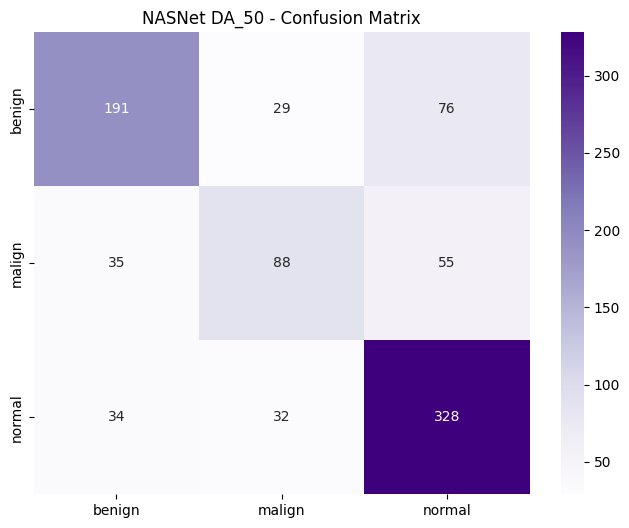


✅ NASNet PURE TEST FINAL ACCURACY: %69.93


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. TEST JENERATÖRÜNÜ YENİDEN OLUŞTUR ---
TEST_DIR = '/content/uclm_full_analysis/elli/test'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

# ResNet'teki gibi aynı mantık: %20 Val / %80 Pure Test ayrımı
test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Hata aldığın o meşhur 'pure_test_gen' burada tekrar doğuyor:
pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # %80'lik asıl test kısmı
    shuffle=False
)

# --- 2. MODELİ YÜKLE VE TAHMİN ET ---
best_model_path = '/content/best_nasnet_DA_50_v3.keras'
if os.path.exists(best_model_path):
    print(f"🔄 NASNet Final Modeli Yükleniyor: {best_model_path}")
    nasnet_final_model = load_model(best_model_path)

    print("🔍 Pure Test seti (868 Resim) taranıyor...")
    Y_pred = nasnet_final_model.predict(pure_test_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = pure_test_gen.classes
    class_labels = list(pure_test_gen.class_indices.keys())

    # --- 3. SONUÇLAR ---
    print("\n🔥 NASNet DA_50 GERÇEK TEST SONUÇLARI:")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('NASNet DA_50 - Confusion Matrix')
    plt.show()

    final_acc = np.sum(y_true == y_pred) / len(y_true)
    print(f"\n✅ NASNet PURE TEST FINAL ACCURACY: %{final_acc*100:.2f}")
else:
    print("❌ HATA: Model dosyası bulunamadı! Lütfen yolu kontrol et.")

NASNET EXTRA

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input # Xception'a özel!
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. YOLLAR ---
BASE_PATH = '/content/elli'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# Xception ön eğitimli (BUSI) modelinin yolu
# Not: Klasör ismindeki büyük/küçük harfe dikkat et, genelde Xception olarak açılır.
MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/xception_model_with_BUSI.keras'

IMAGE_SIZE =(224,224) # Xception en iyi bu boyutta çalışır
BATCH_SIZE = 32
DA_LR = 0.001 # Kazanan öğrenme hızı

# --- 2. VERİ YÜKLEYİCİLER ---
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=False
)

# --- 3. MODELİ YÜKLE VE HAZIRLA ---
print(f"🔄 BUSI Ön Eğitimli Xception yükleniyor...")
if not os.path.exists(MODEL_PATH):
    print(f"❌ HATA: Model bulunamadı! Lütfen yolu kontrol et: {MODEL_PATH}")
else:
    model = load_model(MODEL_PATH)
    model.trainable = True a

    model.compile(optimizer=Adam(learning_rate=DA_LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. CALLBACKS ---
    checkpoint = ModelCheckpoint('/content/best_xception_DA_50.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # --- 5. EĞİTİM ---
    print("\n🚀 Xception DA_30 Eğitimi Başlıyor (LR: 0.0005)...")
    model.fit(
        train_gen,
        epochs=80,
        validation_data=val_gen,
        callbacks=[checkpoint, early_stop]
    )

    # --- 6. DRIVE'A KAYDET ---
    save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/DA_Results/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    model.save(os.path.join(save_dir, "xception_DA_50_final.keras"))
    print(f"✅ Xception DA_30 Modeli başarıyla kaydedildi.")

Found 1081 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Found 868 images belonging to 3 classes.
🔄 BUSI Ön Eğitimli Xception yükleniyor...

🚀 Xception DA_30 Eğitimi Başlıyor (LR: 0.0005)...
Epoch 1/80
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.4784 - loss: 1.6204
Epoch 1: val_accuracy improved from -inf to 0.61395, saving model to /content/best_xception_DA_50.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4786 - loss: 1.6171 - val_accuracy: 0.6140 - val_loss: 1.0134
Epoch 2/80
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.5169 - loss: 1.2910
Epoch 2: val_accuracy improved from 0.61395 to 0.62791, saving model to /content/best_xception_DA_50.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 662ms/step - accuracy: 0.5173 - loss: 1.2891 - val_accuracy: 0.6279 - val_loss: 0.9450
Epoch 3/80
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.5499 - loss: 1.1918
Epoch 3: val_accuracy improved from 0.62791 to 0.66047, saving model to /content/

🔄 Xception DA_50 En İyi Modeli Yükleniyor...
Found 868 images belonging to 3 classes.

🔍 Xception DA_50 Pure Test Başlıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step

🔥 XCEPTION DA_50 PURE TEST SONUÇLARI:
------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.7480    0.6419    0.6909       296
      malign     0.6065    0.5281    0.5646       178
      normal     0.6993    0.8147    0.7526       394

    accuracy                         0.6970       868
   macro avg     0.6846    0.6616    0.6694       868
weighted avg     0.6969    0.6970    0.6930       868



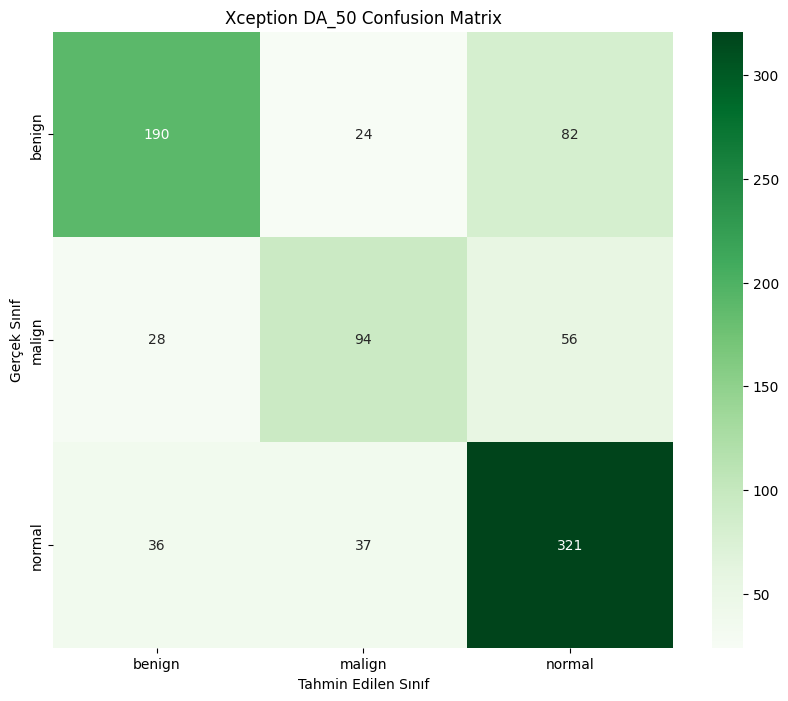


✅ XCEPTION DA_50 FINAL ACCURACY: %69.70


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# 1. En iyi Xception DA_50 modelini yükle
MODEL_PATH = '/content/best_xception_DA_50.keras'
print(f"🔄 Xception DA_50 En İyi Modeli Yükleniyor...")
model = load_model(MODEL_PATH)

# 2. Test Jeneratörü (Pure Test - %80 dilimi)
# Senin verinde Found 868 images belonging to 3 classes diyen kısım
TEST_DIR = '/content/elli/test'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
pure_test_gen = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='training', shuffle=False
)

# 3. Tahminler
print("\n🔍 Xception DA_50 Pure Test Başlıyor...")
Y_pred = model.predict(pure_test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = pure_test_gen.classes
class_labels = list(pure_test_gen.class_indices.keys())

# 4. 4 METRİK VE KARNE
print("\n🔥 XCEPTION DA_50 PURE TEST SONUÇLARI:")
print("-" * 60)
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)

# 5. CONFUSION MATRIX
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Xception DA_50 Confusion Matrix')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

final_acc = np.sum(y_true == y_pred) / len(y_true)
print(f"\n✅ XCEPTION DA_50 FINAL ACCURACY: %{final_acc*100:.2f}")

XCEPTION %50 DOMAİN ADAPTATION


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input # Xception özel preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1. YOLLAR VE AYARLAR ---
BASE_PATH = '/content/uclm_full_analysis/elli'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# ÖNEMLİ: Daha önce BUSI ile eğittiğin Xception modelinin yolu
XCEPTION_MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/xception_model_with_BUSI.keras'

IMAGE_SIZE = (224,224) # Xception'ın standart giriş boyutu 299x299'dur!
BATCH_SIZE = 16
DA_LR = 0.0001

# --- 2. VERİ YÜKLEYİCİLER ---
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

# --- 3. MODELİ YÜKLE ---
print(f"🔄 BUSI Ön Eğitimli Xception yükleniyor...")
if not os.path.exists(XCEPTION_MODEL_PATH):
    print("❌ HATA: Xception Modeli bulunamadı!")
else:
    model = load_model(XCEPTION_MODEL_PATH)
    model.trainable = True # Tüm katmanlar adaptasyon için açık

    model.compile(optimizer=Adam(learning_rate=DA_LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. CALLBACKS ---
    # Model ismi karışmasın diye 'best_xception_DA_50.keras' yaptık
    checkpoint = ModelCheckpoint('/content/best_xception_DA_50.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)

    # --- 5. EĞİTİM ---
    print("\n🚀 Xception DA_50 Eğitimi Başlıyor...")
    model.fit(
        train_gen,
        epochs=30,
        validation_data=val_gen,
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

    # --- 6. KAYDET ---
    save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/DA_Results/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    model.save(os.path.join(save_dir, "xception_DA_50_final.keras"))
    print(f"✅ Xception DA_50 Modeli kaydedildi.")

Found 1081 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
🔄 BUSI Ön Eğitimli Xception yükleniyor...

🚀 Xception DA_50 Eğitimi Başlıyor...
Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.4679 - loss: 1.6968
Epoch 1: val_accuracy improved from -inf to 0.48372, saving model to /content/best_xception_DA_50.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 952ms/step - accuracy: 0.4678 - loss: 1.6967 - val_accuracy: 0.4837 - val_loss: 1.2768 - learning_rate: 1.0000e-04
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.4557 - loss: 1.4970
Epoch 2: val_accuracy improved from 0.48372 to 0.50698, saving model to /content/best_xception_DA_50.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step - accuracy: 0.4558 - loss: 1.4973 - val_accuracy: 0.5070 - val_loss: 1.1694 - learning_rate: 1.0000e-04
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.4907 - loss: 1.4571
Epoch 3: val_accuracy improved from 0.50698 to 0.53953, saving model to /con

In [ ]:
# Modeli 30. epoch ağırlıklarıyla geri yükle
XCEPTION_DA_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/DA_Results/xception_DA_50_final.keras'
model = load_model(XCEPTION_DA_PATH)

# Derle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Eğitim (30 -> 60)
print("\n🚀 Xception DA_50 İkinci Tur (30-60 Epoch) Başlıyor...")
model.fit(
    train_gen,
    epochs=60,
    initial_epoch=30,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Yeni Final Kaydı
final_save_path = "/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/DA_Results/xception_DA_50_60epoch_final.keras"
model.save(final_save_path)


🚀 Xception DA_50 İkinci Tur (30-60 Epoch) Başlıyor...
Epoch 31/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5681 - loss: 1.0737
Epoch 31: val_accuracy did not improve from 0.66512
68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 512ms/step - accuracy: 0.5683 - loss: 1.0734 - val_accuracy: 0.6651 - val_loss: 0.8260 - learning_rate: 1.0000e-04
Epoch 32/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6402 - loss: 0.9126
Epoch 32: val_accuracy did not improve from 0.66512
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - accuracy: 0.6399 - loss: 0.9131 - val_accuracy: 0.6651 - val_loss: 0.8194 - learning_rate: 1.0000e-04
Epoch 33/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5483 - loss: 1.1182
Epoch 33: val_accuracy improved from 0.66512 to 0.66977, saving model to /content/best_xception_DA_50.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - accuracy: 0.5487 - loss: 1.1169 - val_accuracy: 0.6698 - val_loss: 0.8163 - learning_rate: 1.0000e-04
Epoch 34/60
68/68 ━━━━━━━━━━━━━━━━

In [ ]:
import os
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# --- 1. TEMİZLİK VE DOĞRU ÇIKARMA ---
DA_ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/Uclm_for_DA.zip'
TEMP_EXTRACT = '/content/temp_extract'

# Eski hatalı klasörleri silelim ki kafa karışmasın
if os.path.exists('/content/Uclm_for_DA'): shutil.rmtree('/content/Uclm_for_DA')

print(f"📦 {DA_ZIP_PATH} doğrudan /content/ altına açılıyor...")
with zipfile.ZipFile(DA_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('/content/') # Hedef klasör belirtmeden doğrudan köke açıyoruz
print("✅ Açma işlemi bitti.")

# --- 2. YOLLARI DOĞRULAYALIM ---
# Senin verdiğin listeye göre yapı tam olarak bu olmalı:
TRAIN_DIR = '/content/uclm_full_analysis/elli/train'
TEST_DIR = '/content/uclm_full_analysis/elli/test'

if not os.path.exists(TRAIN_DIR):
    print("⚠️ Yol hala bulunamadı! Mevcut klasörleri tarıyorum...")
    # Eğer klasör ismi uclm_full_analysis değil de farklıysa otomatik bulalım
    for root, dirs, files in os.walk('/content/'):
        if 'elli' in dirs and 'train' in os.listdir(os.path.join(root, 'elli')):
            TRAIN_DIR = os.path.join(root, 'elli/train')
            TEST_DIR = os.path.join(root, 'elli/test')
            print(f"✅ Gerçek yol bulundu: {TRAIN_DIR}")
            break

# --- 3. JENERATÖRLER ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
val_gen = test_val_datagen.flow_from_directory(TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=False)

# --- 4. MODEL YÜKLE VE EĞİTİM ---
MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/DA_Results/xception_DA_50_final.keras'
model = load_model(MODEL_PATH)
model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/best_xception_DA_50.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)

print("\n🚀 Xception DA_50 Üçüncü Tur (60-80 Epoch) Başlıyor...")
model.fit(
    train_gen,
    epochs=80,
    initial_epoch=60,
    validation_data=val_gen,
    callbacks=[checkpoint, reduce_lr]
)

# Drive'a Kaydet
model.save("/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/DA_Results/xception_DA_50_80epoch_final.keras")
print("✅ İşlem Başarıyla Tamamlandı.")

📦 /content/drive/MyDrive/Ara Proje/datalar/Uclm_for_DA.zip doğrudan /content/ altına açılıyor...
✅ Açma işlemi bitti.
⚠️ Yol hala bulunamadı! Mevcut klasörleri tarıyorum...
✅ Gerçek yol bulundu: /content/elli/train
Found 1081 images belonging to 3 classes.
Found 215 images belonging to 3 classes.

🚀 Xception DA_50 Üçüncü Tur (60-80 Epoch) Başlıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 61/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.5972 - loss: 0.9501
Epoch 61: val_accuracy improved from -inf to 0.66512, saving model to /content/best_xception_DA_50.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 89s 943ms/step - accuracy: 0.5972 - loss: 0.9500 - val_accuracy: 0.6651 - val_loss: 0.8270 - learning_rate: 2.0000e-04
Epoch 62/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.6122 - loss: 0.9819
Epoch 62: val_accuracy did not improve from 0.66512
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - accuracy: 0.6121 - loss: 0.9817 - val_accuracy: 0.6605 - val_loss: 0.8285 - learning_rate: 2.0000e-04
Epoch 63/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6079 - loss: 0.9369
Epoch 63: val_accuracy did not improve from 0.66512
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 321ms/step - accuracy: 0.6080 - loss: 0.9370 - val_accuracy: 0.6651 - val_loss: 0.8088 - learning_rate: 2.0000e-04
Epoch 64/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5947 - loss: 0.9967
Epoch

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# 1. YOLU TANIMLA
TEST_DIR = '/content/elli/test'

print(f"🔍 Test verileri taranıyor: {TEST_DIR}")

# 2. JENERATÖR
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# 3. MODELİ YÜKLE VE TAHMİN ET
model_path = '/content/best_xception_DA_50.keras'
if os.path.exists(model_path):
    model = load_model(model_path)
    print("🚀 Xception test ediliyor...")

    Y_pred = model.predict(test_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    # 4. SONUÇLAR
    print("\n📝 XCEPTION DA_50 TEST SONUÇLARI:")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

    acc = np.sum(y_true == y_pred) / len(y_true)
    print(f"\n✅ ACCURACY: %{acc*100:.2f}")
else:
    print("❌ HATA: Model bulunamadı!")

🔍 Test verileri taranıyor: /content/elli/test
Found 1083 images belonging to 3 classes.
🚀 Xception test ediliyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 553ms/step

📝 XCEPTION DA_50 TEST SONUÇLARI:
------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.6620    0.6423    0.6520       369
      malign     0.5562    0.4234    0.4808       222
      normal     0.6942    0.7846    0.7366       492

    accuracy                         0.6620      1083
   macro avg     0.6375    0.6168    0.6232      1083
weighted avg     0.6550    0.6620    0.6554      1083


✅ ACCURACY: %66.20


In [ ]:
import os
print("📂 Mevcut Klasör Yapısı:")
for root, dirs, files in os.walk('/content/'):
    level = root.replace('/content/', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    # Sadece ilk 2 seviyeyi görelim ki ekran dolmasın
    if level > 2: break

📂 Mevcut Klasör Yapısı:
/
.config/
    configurations/
    logs/
        2025.12.09/
otuz/
    test/
        normal/
        malign/
        benign/
    train/
        normal/
        malign/
        benign/
elli/
    test/
        normal/
        malign/
        benign/
    train/
        normal/
        malign/
        benign/
drive/
    MyDrive/
        Colab Notebooks/
        course_recommendation (1)/
            course_recommendation/


In [ ]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input

# 1. Denem.zip dosyasını dışarı çıkar
ZIP_PATH = '/content/denem.zip'
EXTRACT_PATH = '/content/denem_xception'

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ denem.zip başarıyla çıkarıldı.")

# 2. Xception Modelini Yükle
model_path = '/content/best_xception_DA_50.keras'
model = load_model(model_path)
print("🔄 Xception Modeli yüklendi. Tahminler başlıyor...\n")

# 3. Tahmin Fonksiyonu
def predict_external_images(folder_path):
    class_labels = ['benign', 'malign', 'normal']
    correct_count = 0
    total_count = 0

    print(f"{'Resim Adı':<45} --> {'Tahmin':<15}")
    print("-" * 70)

    for img_name in sorted(os.listdir(folder_path)):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)

            # Resmi yükle ve Xception formatına hazırla (224x224)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Tahmin yap
            preds = model.predict(img_array, verbose=0)
            score = np.max(preds)
            predicted_class = class_labels[np.argmax(preds)]

            print(f"{img_name:<45} --> {predicted_class} (%{score*100:.2f})")
            total_count += 1

    return total_count

# Testi Başlat
folder_to_test = os.path.join(EXTRACT_PATH, 'denem')
if not os.path.exists(folder_to_test): # Klasör yapısı kontrolü
    folder_to_test = EXTRACT_PATH

predict_external_images(folder_to_test)

✅ denem.zip başarıyla çıkarıldı.
🔄 Xception Modeli yüklendi. Tahminler başlıyor...

Resim Adı                                     --> Tahmin         
----------------------------------------------------------------------
benign (100)-rotated1-rotated2.png            --> normal (%97.58)
benign (101)-rotated1.jpg                     --> benign (%99.98)
benign (101)-sharpened.jpg                    --> benign (%100.00)
benign (102)-rotated2-rotated1.png            --> normal (%78.07)
benign (103)-rotated2-rotated1.png            --> benign (%99.98)
benign (105)-rotated2-rotated2.png            --> benign (%99.99)
benign (105)-rotated2.png                     --> benign (%99.99)
benign (107)-rotated2-sharpened.png           --> benign (%99.80)
benign (108)-rotated2-rotated2.png            --> normal (%60.55)
benign (110)-sharpened-sharpened.png          --> benign (%59.14)
benign (111)-rotated1-sharpened.png           --> benign (%100.00)
malignant (105)-rotated32.png                 --> n

27

ÖYLESİNE DENEME

In [1]:
from google.colab import drive
import zipfile
import os

# 1. Drive'ı bağla
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Senin belirttiğin doğru zip yolu
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/Uclm_for_DA.zip'

# 3. Zip içindeki klasör yapısını (Hiyerarşiyi) kontrol et
if os.path.exists(ZIP_PATH):
    print(f"🔍 {ZIP_PATH} dosyası inceleniyor...\n")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        # Zip içindeki tüm yolları al
        all_files = zip_ref.namelist()

        # İlk 20 dosya yolunu yazdır (Klasör mü değil mi anlamak için)
        print("--- ZIP İÇERİĞİ (İLK 20 SATIR) ---")
        for f in all_files[:20]:
            print(f)

        # "elli" veya "otuz" klasörlerinin olup olmadığını kontrol et
        print("\n--- ÖZEL KONTROL ---")
        print(f"İçinde 'elli' geçiyor mu?: {any('elli' in f.lower() for f in all_files)}")
        print(f"İçinde 'otuz' geçiyor mu?: {any('otuz' in f.lower() for f in all_files)}")
else:
    print(f"❌ HATA: '{ZIP_PATH}' yolunda dosya bulunamadı. Lütfen Drive'daki dosya adını ve yolunu tekrar kontrol et.")

🔍 /content/drive/MyDrive/Ara Proje/datalar/Uclm_for_DA.zip dosyası inceleniyor...

--- ZIP İÇERİĞİ (İLK 20 SATIR) ---
elli/train/normal/FUHI_005.png
elli/train/normal/aug_master_0_1930.png
elli/train/normal/aug_master_0_3837.png
elli/train/normal/aug_master_0_9335.png
elli/train/normal/DAPA_018.png
elli/train/normal/STSP_010.png
elli/train/normal/aug_master_0_9611.png
elli/train/normal/aug_master_0_2190.png
elli/train/normal/ASSC_023.png
elli/train/normal/TOCI_025.png
elli/train/normal/SECH_005.png
elli/train/normal/aug_master_0_3859.png
elli/train/normal/TOCI_016.png
elli/train/normal/aug_master_0_6396.png
elli/train/normal/aug_master_0_4775.png
elli/train/normal/DAPA_000.png
elli/train/normal/aug_master_0_3912.png
elli/train/normal/HUBL_001.png
elli/train/normal/ALWI_024.png
elli/train/normal/aug_master_0_9950.png

--- ÖZEL KONTROL ---
İçinde 'elli' geçiyor mu?: True
İçinde 'otuz' geçiyor mu?: True


In [2]:
import os
from google.colab import drive

# 2. Yolları Tanımla
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/Uclm_for_DA.zip'
TARGET_PATH = '/content/'

# 3. Zip'ten sadece 'elli' klasörünü çıkar
if os.path.exists(ZIP_PATH):
    print(f"📦 {ZIP_PATH} içinden 'elli' klasörü çıkarılıyor...")
    # -q: sessiz mod, -d: hedef dizin
    !unzip -q "{ZIP_PATH}" -d "{TARGET_PATH}"

    # Başarı kontrolü
    if os.path.exists('/content/elli'):
        print("✅ 'elli' klasörü başarıyla oluşturuldu.")
        print("📂 İçerik:", os.listdir('/content/elli'))
    else:
        print("⚠️ Zip çıkarıldı ama 'elli' klasörü bulunamadı. Lütfen ana dizini kontrol et.")
else:
    print(f"❌ HATA: Zip dosyası bulunamadı! Yol: {ZIP_PATH}")

📦 /content/drive/MyDrive/Ara Proje/datalar/Uclm_for_DA.zip içinden 'elli' klasörü çıkarılıyor...
replace /content/elli/train/normal/FUHI_005.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ✅ 'elli' klasörü başarıyla oluşturuldu.
📂 İçerik: ['test', 'train']
